# Check Spectra written in the pickle files


work with Weakly_2023_01
- use jupyter kernel LSST


- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab
- creation date : 2023/02/10
- last update : 2023/02/10


In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.cm as cm 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import numpy as np
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import os,sys,re

from astropy.io import fits
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates
from matplotlib import gridspec
%matplotlib inline
import pickle


In [2]:
import matplotlib.offsetbox
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [3]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 6),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

In [4]:
import time
from datetime import datetime,date
from astropy.time import Time
import dateutil.parser
import pytz

import argparse

import logging
import coloredlogs
import configparser


In [5]:
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from scipy import fftpack

In [6]:
class Line:
    """Class modeling the emission or absorption lines."""

    def __init__(self, wavelength, label, atmospheric=False, emission=False, label_pos=[0.007, 0.02],
                 width_bounds=[0.5, 6], use_for_calibration=False):
        """Class modeling the emission or absorption lines. lines attributes contains main spectral lines
        sorted in wavelength.

        Parameters
        ----------
        wavelength: float
            Wavelength of the spectral line in nm
        label: str

        atmospheric: bool
            Set True if the spectral line is atmospheric (default: False)
        emission: bool
            Set True if the spectral line has to be detected in emission. Can't be true if the line is atmospheric.
            (default: False)
        label_pos: [float, float]
            Position of the label in the plot with respect to the vertical lin (default: [0.007,0.02])
        width_bounds: [float, float]
            Minimum and maximum width (in nm) of the line for fitting procedures (default: [1,7])
        use_for_calibration: bool
            Use this line for the dispersion relation calibration, bright line recommended (default: False)

        Examples
        --------
        >>> l = Line(550, label='test', atmospheric=True, emission=True)
        >>> print(l.wavelength)
        550
        >>> print(l.label)
        test
        >>> print(l.atmospheric)
        True
        >>> print(l.emission)
        False
        """
        self.wavelength = wavelength  # in nm
        self.label = label
        self.label_pos = label_pos
        self.atmospheric = atmospheric
        self.emission = emission
        if self.atmospheric:
            self.emission = False
        self.width_bounds = width_bounds
        self.fitted = False
        self.use_for_calibration = use_for_calibration
        self.high_snr = False
        self.fit_lambdas = None
        self.fit_gauss = None
        self.fit_bgd = None
        self.fit_snr = None
        self.fit_fwhm = None
        self.fit_popt = None
        self.fit_pcov = None
        self.fit_popt_gaussian = None
        self.fit_pcov_gaussian = None
        self.fit_chisq = None
        self.fit_eqwidth_mod = None
        self.fit_eqwidth_data = None
        #self.fit_bgd_npar = parameters.CALIB_BGD_NPARAMS
        self.fit_bgd_npar = None

In [7]:
HALPHA = Line(656.3, atmospheric=False, label='$H\\alpha$', label_pos=[-0.01, 0.02], use_for_calibration=True)
HBETA = Line(486.3, atmospheric=False, label='$H\\beta$', label_pos=[0.001, 0.02], use_for_calibration=True)
HGAMMA = Line(434.0, atmospheric=False, label='$H\\gamma$', label_pos=[0.001, 0.02], use_for_calibration=True)
HDELTA = Line(410.2, atmospheric=False, label='$H\\delta$', label_pos=[0.001, 0.02], use_for_calibration=True)
HEPSILON = Line(397.0, atmospheric=False, label='$H\\epsilon$', label_pos=[0.001, 0.02], use_for_calibration=True)

HZETA = Line(388.9064, atmospheric=False, label='$H\\zeta$', label_pos=[0.001, 0.02], use_for_calibration=False)
HETA = Line(383.5397, atmospheric=False, label='$H\\eta$', label_pos=[0.001, 0.02], use_for_calibration=False)

HBETA2 = Line(486.3*2, atmospheric=False, label='$H\\beta$2', label_pos=[0.001, 0.02], use_for_calibration=True)
HGAMMA2 = Line(434.0*2, atmospheric=False, label='$H\\gamma$2', label_pos=[0.001, 0.02], use_for_calibration=True)
HDELTA2 = Line(410.2*2, atmospheric=False, label='$H\\delta$2', label_pos=[0.001, 0.02], use_for_calibration=True)
HEPSILON2 = Line(397.0*2, atmospheric=False, label='$H\\epsilon$2', label_pos=[0.001, 0.02], use_for_calibration=True)
HZETA2 = Line(388.9064*2, atmospheric=False, label='$H\\zeta$2', label_pos=[0.001, 0.02], use_for_calibration=False)
HETA2 = Line(383.5397*2, atmospheric=False, label='$H\\eta$2', label_pos=[0.001, 0.02], use_for_calibration=False)

O2_1 = Line(760.3, atmospheric=True, label='$O_2$',label_pos=[0.001, 0.02], use_for_calibration=True)  # libradtran paper fig.3
O2_2 = Line(763.1, atmospheric=True, label='$O_2$',label_pos=[0.001, 0.02], use_for_calibration=True)  # libradtran paper fig.3

O2B = Line(687.472, atmospheric=True, label=r'$O_2(B)$',  # 687.472 is a weighted average of the O2B line simulated by Libradtran
           label_pos=[0.001, 0.02], use_for_calibration=True)  # https://en.wikipedia.org/wiki/Fraunhofer_lines
O2Y = Line(898.765, atmospheric=True, label=r'$O_2(Y)$',
           label_pos=[0.001, 0.02])  # https://en.wikipedia.org/wiki/Fraunhofer_lines
O2Z = Line(822.696, atmospheric=True, label=r'$O_2(Z)$',
           label_pos=[0.001, 0.02])  # https://en.wikipedia.org/wiki/Fraunhofer_lines
# H2O = Line( 960,atmospheric=True,label='$H_2 O$',label_pos=[0.007,0.02],width_bounds=(1,50))  #
H2O_1 = Line(935, atmospheric=True, label=r'$H_2 O$', label_pos=[0.001, 0.02],  # MFL: don't these need different labels?
             width_bounds=[5, 30])  # libradtran paper fig.3, broad line
H2O_2 = Line(960, atmospheric=True, label=r'$H_2 O$', label_pos=[0.001, 0.02],  # MFL: don't these need different labels?
              width_bounds=[5, 30])  # libradtran paper fig.3, broad line
ATMOSPHERIC_LINES = [O2_1, O2_2, O2B, O2Y, O2Z, H2O_1]



In [8]:
def smooth_data_convolve_my_average(arr, span):
    re = np.convolve(arr, np.ones(span * 2 + 1) / (span * 2 + 1), mode="same")

    # The "my_average" part: shrinks the averaging window on the side that 
    # reaches beyond the data, keeps the other side the same size as given 
    # by "span"
    re[0] = np.average(arr[:span])
    for i in range(1, span + 1):
        re[i] = np.average(arr[:i + span])
        re[-i] = np.average(arr[-i - span:])
    return re

def smooth_data_np_average(arr, span):  # my original, naive approach
    return [np.average(arr[val - span:val + span + 1]) for val in range(len(arr))]

def smooth_data_np_convolve(arr, span):
    return np.convolve(arr, np.ones(span * 2 + 1) / (span * 2 + 1), mode="same")

def smooth_data_np_cumsum_my_average(arr, span):
    cumsum_vec = np.cumsum(arr)
    moving_average = (cumsum_vec[2 * span:] - cumsum_vec[:-2 * span]) / (2 * span)

    # The "my_average" part again. Slightly different to before, because the
    # moving average from cumsum is shorter than the input and needs to be padded
    front, back = [np.average(arr[:span])], []
    for i in range(1, span):
        front.append(np.average(arr[:i + span]))
        back.insert(0, np.average(arr[-i - span:]))
    back.insert(0, np.average(arr[-2 * span:]))
    return np.concatenate((front, moving_average, back))

def smooth_data_lowess(arr, span):
    x = np.linspace(0, 1, len(arr))
    return sm.nonparametric.lowess(arr, x, frac=(5*span / len(arr)), return_sorted=False)

def smooth_data_kernel_regression(arr, span):
    # "span" smoothing parameter is ignored. If you know how to 
    # incorporate that with kernel regression, please comment below.
    kr = KernelReg(arr, np.linspace(0, 1, len(arr)), 'c')
    return kr.fit()[0]

def smooth_data_savgol_0(arr, span):  
    return savgol_filter(arr, span * 2 + 1, 0)

def smooth_data_savgol_1(arr, span):  
    return savgol_filter(arr, span * 2 + 1, 1)

def smooth_data_savgol_2(arr, span):  
    return savgol_filter(arr, span * 2 + 1, 2)

def smooth_data_fft(arr, span):  # the scaling of "span" is open to suggestions
    w = fftpack.rfft(arr)
    spectrum = w ** 2
    cutoff_idx = spectrum < (spectrum.max() * (1 - np.exp(-span / 2000)))
    w[cutoff_idx] = 0
    return fftpack.irfft(w)

In [9]:
def find_nearest(a, a0):
    "Element in nd array `a` closest to the scalar value `a0`"
    idx = np.abs(a - a0).argmin()
    return a.flat[idx],int(idx)

In [10]:
def GetSpectra(dict_spectra):
    """
    GetSpectra(dict_spectra)
    
    input:
      - dict_spectra : dictionnary of input spectra
      
      
      {'number': 238.0, 'object': 'mu. Col', 'dateobs': '2022-03-18T00:51:22.049', 'refhour': 0.0, 'airmass': 1.11557476948966, 'pressure': 743.45, 'temperature': 8.9, 
      'humidity': 48.0, 'targetx_pix': 312.7442668572934, 'targety_pix': 1738.0006619324693, 'rotangle': 0.1753951396614214, 'd2ccd': 181.0974436798836, 
      'all_lambdas': array([ 302.20970512,  302.91544585,  303.62117594, ..., 1108.67461764,
       1109.35162338, 1110.02859124]), 'all_fluxes': array([1.04110833e-13, 9.83856109e-14, 8.99209206e-14, ...,
       5.34113538e-13, 5.36905940e-13, 5.53127394e-13]), 'all_fluxes_err': array([3.51303583e-15, 3.10100695e-15, 2.58677333e-15, ...,
       3.34568263e-15, 4.01784054e-15, 4.54242555e-15]), 'all_lambdas_order2': array([ 302.24857475,  302.9543149 ,  303.66004442, ..., 1108.71192607,
       1109.38892974, 1110.06589555]), 'all_fluxes_order2': array([420.23653349, 386.95227531, 344.90384603, ...,  60.47440612,
        60.74615545,  62.53491353]), 'all_fluxes_err_order2': array([14.15542468, 12.17674916,  9.90751987, ...,  0.37846535,
        0.45415764,  0.51307916])}
      
    
    return
      - list of dataframes
    """
    
    #correction_area = 1.06/1.13
    correction_area = 1
    
    list_of_columns = ["number","object",'dateobs','refhour','airmass','pressure','temperature','humidity','filename','targetx_pix', 'targety_pix','rotangle', 'd2ccd']   

    all_df = []  # container for spectra
    
    df_info = pd.DataFrame(columns=list_of_columns)
    
    idx=0
    #for key, value in dict_spectra.items():
    sorted_dict_spectra = sorted(dict_spectra.items())
    for key, value in sorted_dict_spectra:    
        df_info.loc[idx] = [int(value["number"]),value["object"],value["dateobs"],value["refhour"],value["airmass"],value["pressure"],value["temperature"],value["humidity"],key,value['targetx_pix'],value['targety_pix'],value['rotangle'], value['d2ccd']]
         
        df = pd.DataFrame()
        df["all_lambdas"] = value["all_lambdas"]
        df["all_fluxes"] = value["all_fluxes"]/ correction_area 
        df["all_fluxes_err"] = value["all_fluxes_err"]
        
        if 'all_lambdas_order2' in value.keys():
            df["all_lambdas_order2"] = value["all_lambdas_order2"]
            df["all_fluxes_order2"] = value["all_fluxes_order2"]/ correction_area 
            df["all_fluxes_err_order2"] = value["all_fluxes_err_order2"]
            
        
        all_df.append(df)
        
        
        idx+=1
        
    return df_info , all_df

In [11]:
def GetSpectraFiltered(dict_spectra,list_of_bad_spectra):
    """
    GetSpectraFiltered(inputdir,inputfiles)
    
    input:
      - dict_spectra
      - ist_of_bad_spectra
    
    return
      - filtered infos, filtered spectra
    """
    
    # factor to correct fluxes (over estimated collection surface)
    #correction_area = 1.06/1.13
    correction_area = 1
    
    
    
    list_of_columns = ["number","object",'dateobs','refhour','airmass','pressure','temperature','humidity','filename','targetx_pix', 'targety_pix','rotangle', 'd2ccd']   
        

    all_df = []  # container for spectra
    
    df_info = pd.DataFrame(columns=list_of_columns)
    
    idx=0       # counter on input spectra
    idx_out = 0 # counter on save spectra
    #for key, value in dict_spectra.items():
    sorted_dict_spectra = sorted(dict_spectra.items())
    for key, value in sorted_dict_spectra:    
        
        
        if int(value["number"]) not in list_of_bad_spectra:
        
            
            df_info.loc[idx] = [int(value["number"]),value["object"],value["dateobs"],value["refhour"],value["airmass"],value["pressure"],value["temperature"],value["humidity"],key,value['targetx_pix'],value['targety_pix'],value['rotangle'], value['d2ccd']] 
        
            df = pd.DataFrame()
            df["all_lambdas"] = value["all_lambdas"]
            df["all_fluxes"] = value["all_fluxes"]/correction_area
            df["all_fluxes_err"] = value["all_fluxes_err"]
        
            if 'all_lambdas_order2' in value.keys():
                df["all_lambdas_order2"] = value["all_lambdas_order2"]
                df["all_fluxes_order2"] = value["all_fluxes_order2"]/correction_area
                df["all_fluxes_err_order2"] = value["all_fluxes_err_order2"]
               
            all_df.append(df)
            idx_out+=1  # increase count on saved spectra
            
        else:
            num = int(value["number"])
            msg = f"Remove spectrum {idx} for exposure {num}"
            print(msg)
            
        idx+=1
            

        
    return df_info,all_df

# Initialisation 

In [12]:
# start with logs
#-----------------
logging.basicConfig()
logging.root.setLevel(logging.NOTSET)

handle = __name__

logger = logging.getLogger(handle)
# logging.getLogger().setLevel(logging.INFO)
logger.setLevel(logging.DEBUG)

# If you don't want to see log messages from libraries, you can pass a
# specific logger object to the install() function. In this case only log
# messages originating from that logger will show up on the terminal.
coloredlogs.install(level='DEBUG', logger=logger)
coloredlogs.install(fmt='%(asctime)s,%(msecs)03d %(hostname)s %(name)s[%(process)d] %(levelname)s %(message)s')

## Throughputs

In [13]:
filename_OG550_throughput ="../../../simulation/throughputs/OG550_65mm_1.txt"

In [14]:
arr_th = np.loadtxt(filename_OG550_throughput)

(0.0, 1100.0)

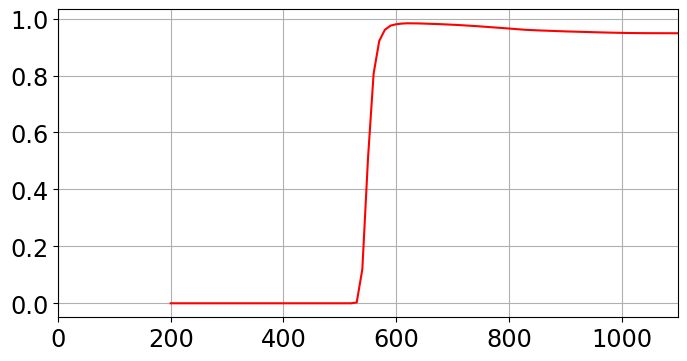

In [15]:
plt.figure(figsize=(8,4))
plt.plot(arr_th[:,0],arr_th[:,1],'r-')
plt.grid()
plt.xlim(0,1100)

In [16]:
f_transm_og550 = interpolate.interp1d(arr_th[:,0],arr_th[:,1],fill_value="extrapolate")

In [17]:
f_transm_og550([50.,100.,1000.])

array([1.000e-05, 1.000e-05, 9.499e-01])

## Input file

In [18]:
!ls extracted_spectra/OG550_65mm_1~holo4_003

run-auxtel-holo-20230117-OG550_65mm_1~holo4_003-PSF2DFFM_REBIN2-oga.pickle
run-auxtel-holo-20230118-OG550_65mm_1~holo4_003-PSF2DFFM_REBIN2-oga.pickle
run-auxtel-holo-20230119-OG550_65mm_1~holo4_003-PSF2DFFM_REBIN2-oga.pickle
run-auxtel-holo-20230202-OG550_65mm_1~holo4_003-PSF2DFFM_REBIN1-oga.pickle
run-auxtel-holo-20230202-OG550_65mm_1~holo4_003-PSF2DFFM_REBIN2-oga.pickle


In [19]:
the_date = 20230118
the_filtertype1 = "empty~holo4_003"
the_filtertype2 = "OG550_65mm_1~holo4_003"
path1=os.path.join("./extracted_spectra",the_filtertype1)
path2=os.path.join("./extracted_spectra",the_filtertype2)

list_of_badnums1 = []

if the_date == 20230117:
    ##input_filename = "run-auxtel-holo-20230117-empty~holo4_003-PSF2DFFM_REBIN2.pickle"
    ##list_of_badnums1 = [240,348]
    
    #input_filename = "run-auxtel-holo-20230117-empty~holo4_003-PSF2DFFM_REBIN2_b.pickle"
    #list_of_badnums1 = [239,243,265,285,326,334,348,376,390,457,477,524,535,607,608,616,617,647]
    
    #input_filename = "run-auxtel-holo-20230117-empty~holo4_003-PSF2DFFM_REBIN1-oga.pickle"
    #list_of_badnums1 = [238,239,248,249,265,285,297,298,349,375,376,389,390,447,487,505,506,524,543,599,617,660,661,669]
    
    
    #input_filename ="run-auxtel-holo-20230117-OG550_65mm_1~holo4_003-PSF2DFFM_REBIN2-oga.pickle"
    pass
    
elif the_date == 20230118:
    ##input_filename = "run-auxtel-holo-20230118-empty~holo4_003-PSF2DFFM_REBIN2.pickle"
    
    input_filename1 = "run-auxtel-holo-20230118-empty~holo4_003-PSF2DFFM_REBIN2_b.pickle"
    list_of_badnums1 = [208,312,313,322,420,463,464,482,563,564,618,626,627,707]
    
    
    #input_filename = "run-auxtel-holo-20230118-empty~holo4_003-PSF2DFFM_REBIN1-oga.pickle"
    #list_of_badnums1 = [208,273,374,396,408,431,432,463,472,473,502,539,540,554,573,591,600,617,626,636,644,645,654,671,672,690,698,707]
    
    input_filename2 = "run-auxtel-holo-20230118-OG550_65mm_1~holo4_003-PSF2DFFM_REBIN2-oga.pickle"
    pass
    
elif the_date == 20230119:
    ##input_filename = "run-auxtel-holo-20230119-empty~holo4_003-PSF2DFFM_REBIN2.pickle"
    #input_filename = "run-auxtel-holo-20230119-empty~holo4_003-PSF2DFFM_REBIN2_b.pickle"
    #list_of_badnums1 = [218,287,288,393]
    
    #input_filename = "run-auxtel-holo-20230119-OG550_65mm_1~holo4_003-PSF2DFFM_REBIN2-oga.pickle"
    pass
elif the_date == 20230202:
    #input_filename = "run-auxtel-holo-20230202-OG550_65mm_1~holo4_003-PSF2DFFM_REBIN1-oga.pickle"
    #input_filename = "run-auxtel-holo-20230202-OG550_65mm_1~holo4_003-PSF2DFFM_REBIN2-oga.pickle"
    pass
else:
    msg = f"No valid date spected {the_date}"
    logger.errir(msg)
    

# Start

In [20]:
# set time
# date
today = date.today()
string_date = today.strftime("%Y-%m-%d")

# time
now = datetime.now()
current_time = now.strftime("%H:%M:%S")

tim = time.localtime()
current_time = time.strftime("%H:%M:%S", tim)

# timezones
tz_LA = pytz.timezone('America/Los_Angeles')
datetime_LA = datetime.now(tz_LA)
msg="LA time:"+  datetime_LA.strftime("%H:%M:%S")
logger.info(msg)

tz_NY = pytz.timezone('America/New_York')
datetime_NY = datetime.now(tz_NY)
msg="NY time:"+ datetime_NY.strftime("%H:%M:%S")
logger.info(msg)

tz_London = pytz.timezone('Europe/London')
datetime_London = datetime.now(tz_London)
msg="London time:"+ datetime_London.strftime("%H:%M:%S")
logger.info(msg)

tz_Paris = pytz.timezone('Europe/Paris')
datetime_Paris = datetime.now(tz_Paris)
msg="Paris time:"+ datetime_Paris.strftime("%H:%M:%S")
logger.info(msg)



2023-02-10 17:02:04,342 imacdagoret.lal.in2p3.fr __main__[34329] INFO LA time:08:02:04
2023-02-10 17:02:04,343 imacdagoret.lal.in2p3.fr __main__[34329] INFO NY time:11:02:04
2023-02-10 17:02:04,345 imacdagoret.lal.in2p3.fr __main__[34329] INFO London time:16:02:04
2023-02-10 17:02:04,346 imacdagoret.lal.in2p3.fr __main__[34329] INFO Paris time:17:02:04


# Read input file

In [21]:
fullfilename1=os.path.join(path1,input_filename1)
fullfilename2=os.path.join(path2,input_filename2)

In [22]:
! ls extracted_spectra/OG550_65mm_1~holo4_003/run-auxtel-holo-20230118-OG550_65mm_1~holo4_003-PSF2DFFM_REBIN2-oga.pickle

extracted_spectra/OG550_65mm_1~holo4_003/run-auxtel-holo-20230118-OG550_65mm_1~holo4_003-PSF2DFFM_REBIN2-oga.pickle


In [23]:
print(fullfilename2)

./extracted_spectra/OG550_65mm_1~holo4_003/run-auxtel-holo-20230118-OG550_65mm_1~holo4_003-PSF2DFFM_REBIN2-oga.pickle


In [24]:
with open(fullfilename1, 'rb') as f:
    summary_content1 = pickle.load(f)
with open(fullfilename2, 'rb') as f:
    summary_content2 = pickle.load(f)

In [25]:
NBSPECTRA1=len(summary_content1)
NBSPECTRA2=len(summary_content2)
NBSPECTRA=max(NBSPECTRA1,NBSPECTRA2)

In [26]:
msg=f" Number of selected files is {NBSPECTRA1} in {the_filtertype1}"
logger.info(msg)
msg=f" Number of selected files is {NBSPECTRA2} in {the_filtertype2}"
logger.info(msg)

2023-02-10 17:02:04,502 imacdagoret.lal.in2p3.fr __main__[34329] INFO  Number of selected files is 77 in empty~holo4_003
2023-02-10 17:02:04,503 imacdagoret.lal.in2p3.fr __main__[34329] INFO  Number of selected files is 71 in OG550_65mm_1~holo4_003


In [27]:
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBSPECTRA)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBSPECTRA), alpha=1)

## Read all spectra

In [28]:
infos1, all_spectra1 = GetSpectra(summary_content1)
infos2, all_spectra2 = GetSpectra(summary_content2)

In [29]:
infos1

,number,object,dateobs,refhour,airmass,pressure,temperature,humidity,filename,targetx_pix,targety_pix,rotangle,d2ccd
0,207,HD38666,2023-01-19T00:51:33.404506808Z,-0.772564,1.083301,0,0,0,2023011800207,265.933638,1723.761199,0.238079,177.776883
1,208,HD38666,2023-01-19T00:52:16.221000908Z,-0.760670,1.082111,0,0,0,2023011800208,2589.564522,1739.449000,-0.023146,175.973021
2,217,HD38666,2023-01-19T00:57:43.847004258Z,-0.669663,1.073385,0,0,0,2023011800217,246.117122,1725.495641,0.238082,184.827953
3,226,HD38666,2023-01-19T01:02:55.506003157Z,-0.583091,1.066001,0,0,0,2023011800226,329.343523,1753.566441,0.229454,180.231881
4,227,HD38666,2023-01-19T01:03:38.322003085Z,-0.571198,1.064966,0,0,0,2023011800227,332.072016,1753.023332,0.228991,180.029127
...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,707,HD38666,2023-01-19T07:48:03.747503014Z,6.169198,2.353548,0,0,0,2023011800707,2580.776055,1762.093571,-1.233804,179.024063
73,730,HD111980,2023-01-19T08:06:41.270009476Z,6.479621,1.101852,0,0,0,2023011800730,303.093301,1724.588941,0.243337,180.009688
74,731,HD111980,2023-01-19T08:07:24.086003293Z,6.491514,1.100586,0,0,0,2023011800731,301.033603,1728.436531,0.240263,179.991946
75,753,HD185975,2023-01-19T08:24:50.606000576Z,6.782214,2.094363,0,0,0,2023011800753,295.593348,1761.194049,0.482193,180.035579


## Polar

In [30]:
seq_num_polarnofilt = 407
df_polar_nofilt = infos1[infos1.number == seq_num_polarnofilt ]
idx_polar_nofilt = df_polar_nofilt.index[0]
airmass_polar_nofilt = df_polar_nofilt.airmass.values[0]
target_polar_nofilt = df_polar_nofilt.object.values[0]
the_spectrum_polar_nofilt = all_spectra1[idx_polar_nofilt]

In [31]:
seq_num_polarwtfilt = 411
df_polar_wtfilt = infos2[infos2.number == seq_num_polarwtfilt ]
idx_polar_wtfilt = df_polar_wtfilt.index[0]
airmass_polar_wtfilt = df_polar_wtfilt.airmass.values[0]
target_polar_wtfilt = df_polar_wtfilt.object.values[0]
the_spectrum_polar_wtfilt = all_spectra2[idx_polar_wtfilt]
transm_og = f_transm_og550(the_spectrum_polar_wtfilt.all_lambdas.values)
transm_og = 0.92

(0.0, 1.3e-12)

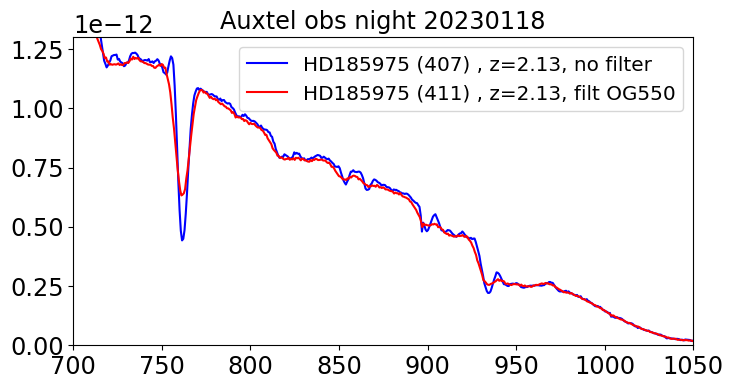

In [32]:
plt.figure(figsize=(8,4))
label=f"{target_polar_nofilt} ({seq_num_polarnofilt}) , z={airmass_polar_nofilt:.2f}, no filter"
plt.plot(the_spectrum_polar_nofilt.all_lambdas,the_spectrum_polar_nofilt.all_fluxes,'b-',label=label)
label=f"{target_polar_wtfilt} ({seq_num_polarwtfilt}) , z={airmass_polar_wtfilt:.2f}, filt OG550"
plt.plot(the_spectrum_polar_wtfilt.all_lambdas,the_spectrum_polar_wtfilt.all_fluxes/transm_og ,'r-',label=label)
the_title = f"Auxtel obs night {the_date}"
plt.legend()
plt.title(the_title)
plt.xlim(700,1050)
plt.ylim(0,1.3e-12)

In [33]:
seq_num_polarnofilt = 431
df_polar_nofilt = infos1[infos1.number == seq_num_polarnofilt ]
idx_polar_nofilt = df_polar_nofilt.index[0]
airmass_polar_nofilt = df_polar_nofilt.airmass.values[0]
target_polar_nofilt = df_polar_nofilt.object.values[0]
the_spectrum_polar_nofilt = all_spectra1[idx_polar_nofilt]

In [34]:
seq_num_polarwtfilt = 436
df_polar_wtfilt = infos2[infos2.number == seq_num_polarwtfilt ]
idx_polar_wtfilt = df_polar_wtfilt.index[0]
airmass_polar_wtfilt = df_polar_wtfilt.airmass.values[0]
target_polar_wtfilt = df_polar_wtfilt.object.values[0]
the_spectrum_polar_wtfilt = all_spectra2[idx_polar_wtfilt]
transm_og = f_transm_og550(the_spectrum_polar_wtfilt.all_lambdas.values)
transm_og = 0.92

(0.0, 1.3e-12)

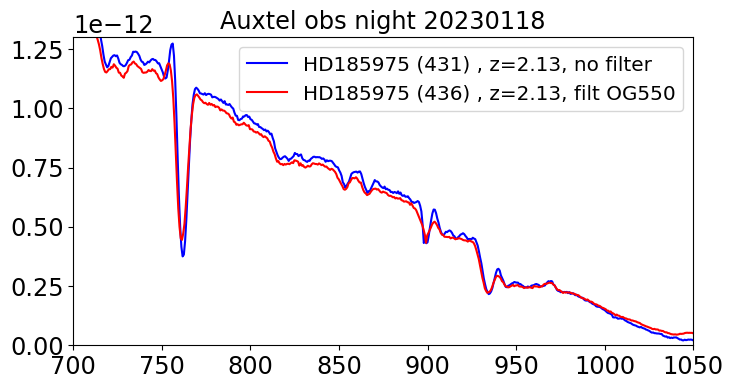

In [35]:
plt.figure(figsize=(8,4))
label=f"{target_polar_nofilt} ({seq_num_polarnofilt}) , z={airmass_polar_nofilt:.2f}, no filter"
plt.plot(the_spectrum_polar_nofilt.all_lambdas,the_spectrum_polar_nofilt.all_fluxes,'b-',label=label)
label=f"{target_polar_wtfilt} ({seq_num_polarwtfilt}) , z={airmass_polar_wtfilt:.2f}, filt OG550"
plt.plot(the_spectrum_polar_wtfilt.all_lambdas,the_spectrum_polar_wtfilt.all_fluxes/transm_og,'r-',label=label)
the_title = f"Auxtel obs night {the_date}"
plt.legend()
plt.title(the_title)
plt.xlim(700,1050)
plt.ylim(0,1.3e-12)

In [36]:
seq_num_polarnofilt = 698
df_polar_nofilt = infos1[infos1.number == seq_num_polarnofilt ]
idx_polar_nofilt = df_polar_nofilt.index[0]
airmass_polar_nofilt = df_polar_nofilt.airmass.values[0]
target_polar_nofilt = df_polar_nofilt.object.values[0]
the_spectrum_polar_nofilt = all_spectra1[idx_polar_nofilt]

In [37]:
seq_num_polarwtfilt = 702
df_polar_wtfilt = infos2[infos2.number == seq_num_polarwtfilt ]
idx_polar_wtfilt = df_polar_wtfilt.index[0]
airmass_polar_wtfilt = df_polar_wtfilt.airmass.values[0]
target_polar_wtfilt = df_polar_wtfilt.object.values[0]
the_spectrum_polar_wtfilt = all_spectra2[idx_polar_wtfilt]
transm_og = f_transm_og550(the_spectrum_polar_wtfilt.all_lambdas.values)
transm_og = 0.92

(0.0, 1.3e-12)

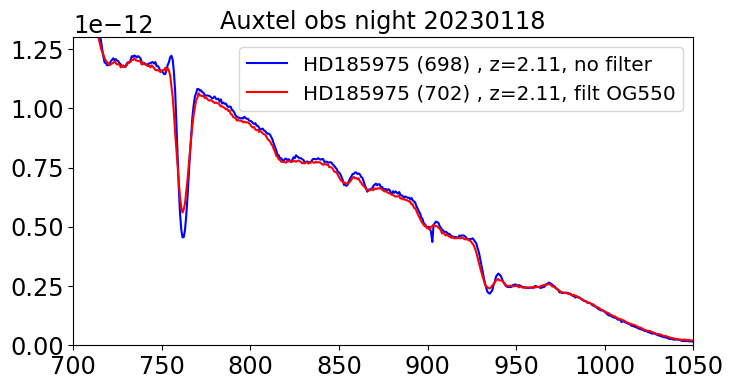

In [38]:
plt.figure(figsize=(8,4))
label=f"{target_polar_nofilt} ({seq_num_polarnofilt}) , z={airmass_polar_nofilt:.2f}, no filter"
plt.plot(the_spectrum_polar_nofilt.all_lambdas,the_spectrum_polar_nofilt.all_fluxes,'b-',label=label)
label=f"{target_polar_wtfilt} ({seq_num_polarwtfilt}) , z={airmass_polar_wtfilt:.2f}, filt OG550"
plt.plot(the_spectrum_polar_wtfilt.all_lambdas,the_spectrum_polar_wtfilt.all_fluxes/transm_og,'r-',label=label)
the_title = f"Auxtel obs night {the_date}"
plt.legend()
plt.title(the_title)
plt.xlim(700,1050)
plt.ylim(0,1.3e-12)

## MuCol

In [39]:
seq_num_mucolnofilt = 444
df_mucol_nofilt = infos1[infos1.number == seq_num_mucolnofilt ]
idx_mucol_nofilt = df_mucol_nofilt.index[0]
airmass_mucol_nofilt = df_mucol_nofilt.airmass.values[0]
target_mucol_nofilt = df_mucol_nofilt.object.values[0]
the_spectrum_mucol_nofilt = all_spectra1[idx_mucol_nofilt]

In [40]:
seq_num_mucolwtfilt = 423
df_mucol_wtfilt = infos2[infos2.number == seq_num_mucolwtfilt ]
idx_mucol_wtfilt = df_mucol_wtfilt.index[0]
airmass_mucol_wtfilt = df_mucol_wtfilt.airmass.values[0]
target_mucol_wtfilt = df_mucol_wtfilt.object.values[0]
the_spectrum_mucol_wtfilt = all_spectra2[idx_mucol_wtfilt]
transm_og = f_transm_og550(the_spectrum_mucol_wtfilt.all_lambdas.values)
transm_og =  0.92

(0.0, 1e-11)

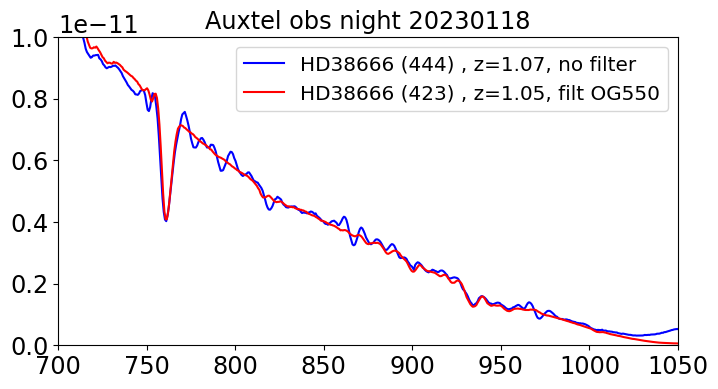

In [41]:
plt.figure(figsize=(8,4))
label=f"{target_mucol_nofilt} ({seq_num_mucolnofilt}) , z={airmass_mucol_nofilt:.2f}, no filter"
plt.plot(the_spectrum_mucol_nofilt.all_lambdas,the_spectrum_mucol_nofilt.all_fluxes,'b-',label=label)
label=f"{target_mucol_wtfilt} ({seq_num_mucolwtfilt}) , z={airmass_mucol_wtfilt:.2f}, filt OG550"
plt.plot(the_spectrum_mucol_wtfilt.all_lambdas,the_spectrum_mucol_wtfilt.all_fluxes/transm_og,'r-',label=label)
the_title = f"Auxtel obs night {the_date}"
plt.legend()
plt.title(the_title)
plt.xlim(700,1050)
plt.ylim(0,1e-11)

In [42]:
seq_num_mucolnofilt = 444
df_mucol_nofilt = infos1[infos1.number == seq_num_mucolnofilt ]
idx_mucol_nofilt = df_mucol_nofilt.index[0]
airmass_mucol_nofilt = df_mucol_nofilt.airmass.values[0]
target_mucol_nofilt = df_mucol_nofilt.object.values[0]
the_spectrum_mucol_nofilt = all_spectra1[idx_mucol_nofilt]

In [43]:
seq_num_mucolwtfilt = 449
df_mucol_wtfilt = infos2[infos2.number == seq_num_mucolwtfilt ]
idx_mucol_wtfilt = df_mucol_wtfilt.index[0]
airmass_mucol_wtfilt = df_mucol_wtfilt.airmass.values[0]
target_mucol_wtfilt = df_mucol_wtfilt.object.values[0]
the_spectrum_mucol_wtfilt = all_spectra2[idx_mucol_wtfilt]
transm_og = f_transm_og550(the_spectrum_mucol_wtfilt.all_lambdas.values)
transm_og = 0.92

(0.0, 1e-11)

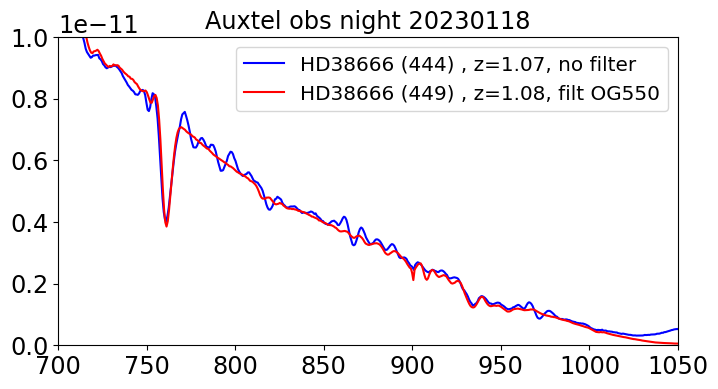

In [44]:
plt.figure(figsize=(8,4))
label=f"{target_mucol_nofilt} ({seq_num_mucolnofilt}) , z={airmass_mucol_nofilt:.2f}, no filter"
plt.plot(the_spectrum_mucol_nofilt.all_lambdas,the_spectrum_mucol_nofilt.all_fluxes,'b-',label=label)
label=f"{target_mucol_wtfilt} ({seq_num_mucolwtfilt}) , z={airmass_mucol_wtfilt:.2f}, filt OG550"
plt.plot(the_spectrum_mucol_wtfilt.all_lambdas,the_spectrum_mucol_wtfilt.all_fluxes/transm_og,'r-',label=label)
the_title = f"Auxtel obs night {the_date}"
plt.legend()
plt.title(the_title)
plt.xlim(700,1050)
plt.ylim(0,1e-11)

In [45]:
seq_num_mucolnofilt = 690
df_mucol_nofilt = infos1[infos1.number == seq_num_mucolnofilt ]
idx_mucol_nofilt = df_mucol_nofilt.index[0]
airmass_mucol_nofilt = df_mucol_nofilt.airmass.values[0]
target_mucol_nofilt = df_mucol_nofilt.object.values[0]
the_spectrum_mucol_nofilt = all_spectra1[idx_mucol_nofilt]

In [46]:
seq_num_mucolwtfilt = 693
df_mucol_wtfilt = infos2[infos2.number == seq_num_mucolwtfilt ]
idx_mucol_wtfilt = df_mucol_wtfilt.index[0]
airmass_mucol_wtfilt = df_mucol_wtfilt.airmass.values[0]
target_mucol_wtfilt = df_mucol_wtfilt.object.values[0]
the_spectrum_mucol_wtfilt = all_spectra2[idx_mucol_wtfilt]
transm_og = f_transm_og550(the_spectrum_mucol_wtfilt.all_lambdas.values)
transm_og = 0.92

(0.0, 1e-11)

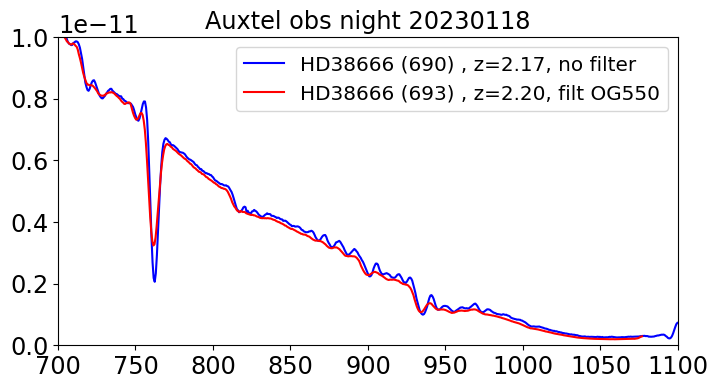

In [47]:
plt.figure(figsize=(8,4))
label=f"{target_mucol_nofilt} ({seq_num_mucolnofilt}) , z={airmass_mucol_nofilt:.2f}, no filter"
plt.plot(the_spectrum_mucol_nofilt.all_lambdas,the_spectrum_mucol_nofilt.all_fluxes,'b-',label=label)
label=f"{target_mucol_wtfilt} ({seq_num_mucolwtfilt}) , z={airmass_mucol_wtfilt:.2f}, filt OG550"
plt.plot(the_spectrum_mucol_wtfilt.all_lambdas,the_spectrum_mucol_wtfilt.all_fluxes/transm_og +.15e-12,'r-',label=label)
the_title = f"Auxtel obs night {the_date}"
plt.legend()
plt.title(the_title)
plt.xlim(700,1100)
plt.ylim(0,1e-11)